# Sites by layer

create and activate env from `npx_10m_384ch_unit_classes.txt`

In [1]:
import os 
import h5py
from matplotlib import pyplot as plt
import numpy as np
from voxcell.nexus.voxelbrain import Atlas
import pandas as pd

PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/sfn_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.load import load_campaign_params
from src.nodes.dataeng.silico.filtering import filter_microcircuit_cells
from src.nodes import viz 

# SET EXPERIMENT PARAMETERS
EXP = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"

# SET RUN PARAMETERS
N_CONTACTS = 384
N_CONTACTS_TO_KEEP = 32
CONTACTS_TO_KEEP = np.arange(127, 127+N_CONTACTS_TO_KEEP) # 127 to 127+32

# SETUP EXPERIMENT CONFIG
data_conf, param_conf = get_config(EXP, SIMULATION_DATE).values()

# GET PATHS
WEIGHT_PATH = data_conf["campaign"]["source_weights"]

2023-10-17 17:58:18,453 - root - utils.py - get_config - INFO - Reading experiment config.
2023-10-17 17:58:18,491 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Custom functions

In [2]:
def getAtlasInfo(BlueConfig, electrodePositions):
    """get electrode layer
    author: Joseph Tharayil

    Args:
        BlueConfig (_type_): _description_
        electrodePositions (_type_): _description_
    """

    bluefile = open(BlueConfig,'r')
    bluelines = bluefile.readlines()
    bluefile.close()

    for line in bluelines:
        if 'Atlas' in line:
            atlasName = line.split('Atlas ')[-1].split('\n')[0]
            break

    atlas = Atlas.open(atlasName)
    brain_regions = atlas.load_data('brain_regions')

    region_map = atlas.load_region_map()

    regionList = []
    layerList = []

    for position in electrodePositions:
        try:
            for id_ in brain_regions.lookup([position]):

                region = region_map.get(id_, 'acronym')
                regionList.append(region.split(';')[0])
                layerList.append(region.split(';')[1])

        except:
            regionList.append('Outside')
            layerList.append('Outside')
    
    return layerList

### Get contacts coordinates

In [4]:
# read weight file
weights = h5py.File(WEIGHT_PATH,'r')

# describe keys
print("\nWeight keys:",weights.keys())

# test the number of contacts
assert N_CONTACTS == weights["electrodes"]["electrode_grid"]["1000036"].shape[1], "The number of contacts is unexpected"

# set contacts ids
all_contacts_ids = np.arange(0, N_CONTACTS)

# get all contact locations
all_contact_locations = []
for all_contact_i in all_contacts_ids:
    all_contact_locations.append(eval(f"""weights["electrodes"]["Neuropixels-384_{all_contact_i}"]["location"][:]""").tolist())
all_contact_locations = np.array(all_contact_locations)

# test number of contacts
assert len(list(weights["electrodes"].keys())[:-1]) == N_CONTACTS, "number of contacts do not match expectation"

selected_contacts_coords = []
for contact_i in CONTACTS_TO_KEEP:
    selected_contacts_coords.append(eval(f"""weights["electrodes"]["Neuropixels-384_{contact_i}"]["location"][:]""").tolist())
selected_contacts_coords = np.array(selected_contacts_coords)

# weights['electrodes']["Neuropixels-384_0"].keys()
print(weights['electrodes']["Neuropixels-384_128"].keys())
for contact_i in CONTACTS_TO_KEEP:
    print(weights['electrodes'][f"Neuropixels-384_{contact_i}"]["layer"])

# close file
# weights.close()


Weight keys: <KeysViewHDF5 ['electrodes', 'neuron_ids', 'offsets', 'sec_ids']>
<KeysViewHDF5 ['layer', 'location', 'offset', 'region', 'type']>
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "layer": shape (), type "|O">
<HDF5 dataset "laye

### Get electrode layers

In [5]:
# get electrode layers
layers = getAtlasInfo(data_conf["dataeng"]["blueconfig"], all_contact_locations)

# print
contact_layer_df = pd.DataFrame([all_contacts_ids, layers]).T
contact_layer_df.columns=["contact", "layer"]
contact_layer_df

,contact,layer
0,0,Outside
1,1,Outside
2,2,Outside
3,3,Outside
4,4,Outside
...,...,...
379,379,Outside
380,380,Outside
381,381,Outside
382,382,Outside


contacts 118 to 168

In [6]:
# print electrodes inside the circuit
inside_circuit = contact_layer_df[contact_layer_df["layer"]!="Outside"]["contact"].values

print("contacts inside circuit (count):", len(inside_circuit))

print("contacts inside circuit (ids):")
print(inside_circuit)

# get layerss of contacts inside circuit
layer_contact_in_circuit_df = contact_layer_df[contact_layer_df["contact"].isin(inside_circuit)]
layer_contact_in_circuit_df

contacts inside circuit (count): 202
contacts inside circuit (ids):
[23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 256 257 258 259 260 261 262 263 264 310 311 312 313 314 315
 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333
 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351
 352 353 354 355 356 357 358 359 360]


/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/3_sfn_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


,contact,layer
23,23,L6
24,24,L6
25,25,L6
26,26,L6
27,27,L6
...,...,...
356,356,L2
357,357,L1
358,358,L1
359,359,L1


### Get cell layers

In [7]:
# Get coordinates of a sample of the column cells (else rendering last a while)
simulation = load_campaign_params(data_conf)
microcircuit = filter_microcircuit_cells(simulation)
microcircuit_coord = microcircuit["soma_location"].sample(n=10000, axis=0, random_state=1)

# get cell layers
cell_layers = simulation["circuit"].cells.get(group=microcircuit["gid"], properties="layer")

/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/3_sfn_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/3_sfn_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/3_sfn_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


### Plot

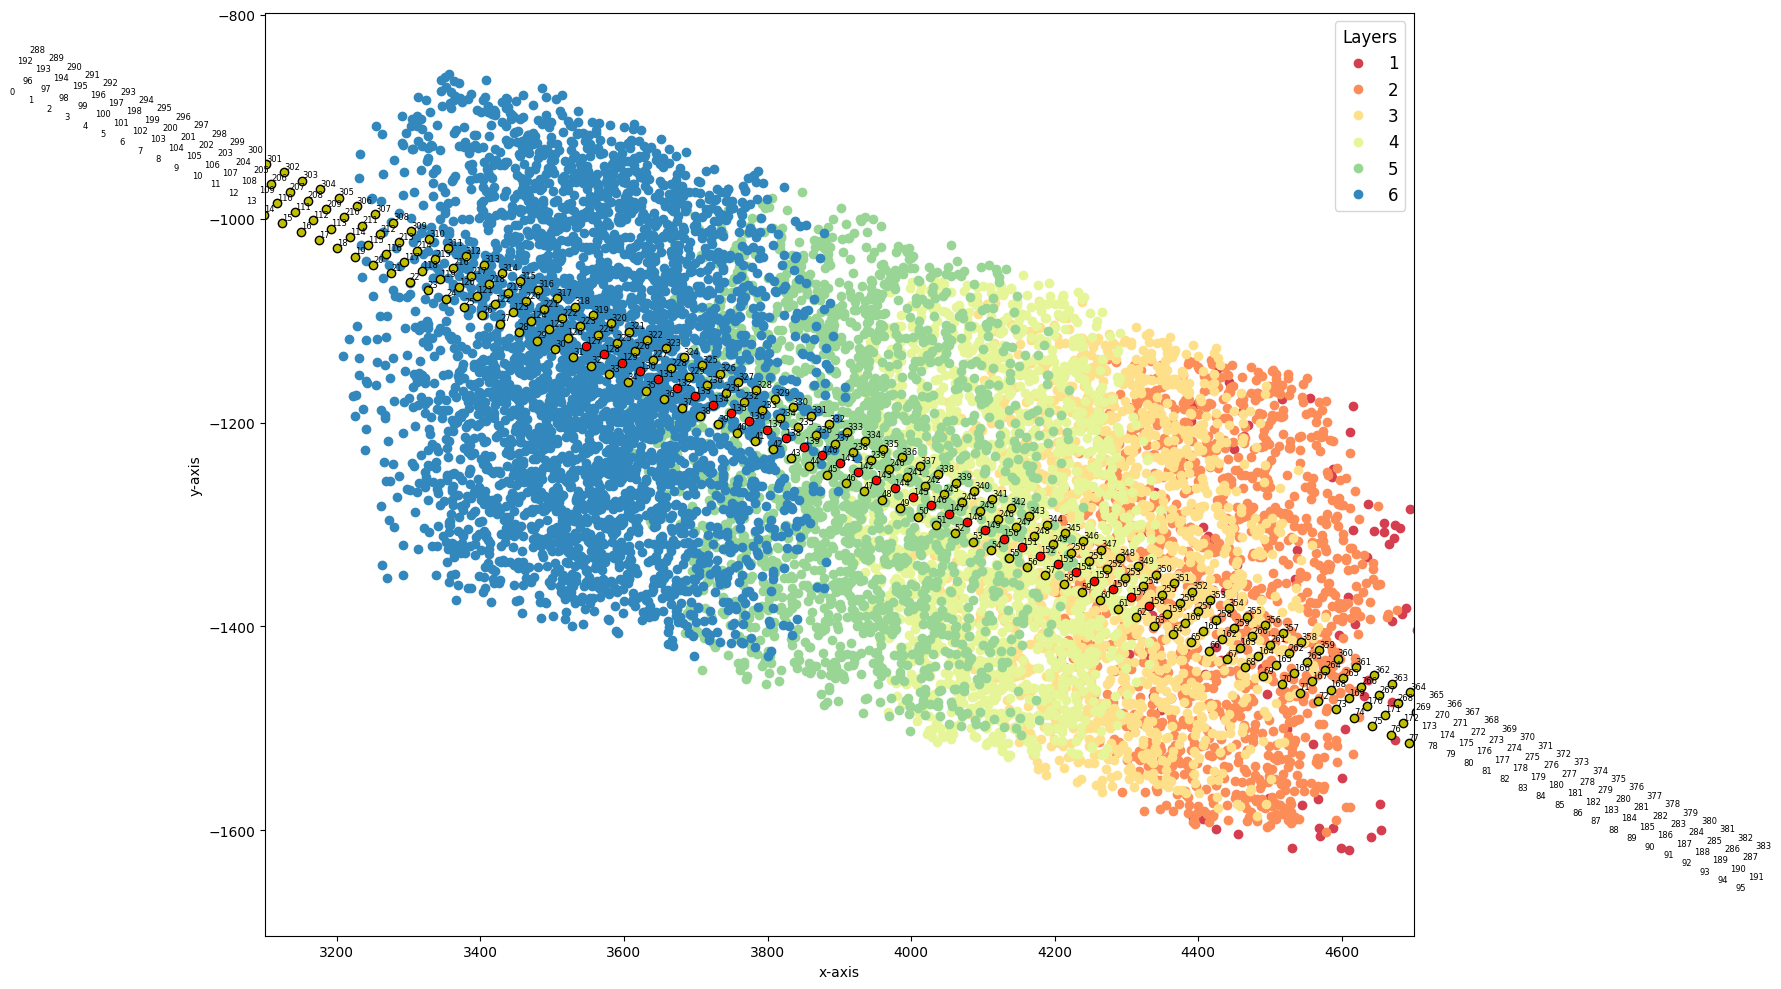

In [18]:
# angle view 4
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# plot cells colored by layer
layer_color = [
    (0,0,0),
    (213/255, 62/255, 79/255),
    (252/255, 141/255, 89/255),
    (254/255, 224/255, 139/255),
    (230/255, 245/255, 152/255),
    (153/255, 213/255, 148/255),
    (50/255, 136/255, 189/255)
    ]

layers = np.sort(cell_layers.unique())

for layer_i in layers:
    ax.plot(
        microcircuit_coord.x[cell_layers==layer_i],
        microcircuit_coord.y[cell_layers==layer_i],
        ".",
        color=layer_color[int(layer_i)],
        markersize=12,
    )

# add contacts
ax.plot(
    all_contact_locations[:, 0],
    all_contact_locations[:, 1],
    marker=".",
    markersize=12,
    color="y",
    markeredgecolor="black",
    linestyle="None",
)

# add selected contacts
ax.plot(
    selected_contacts_coords[:, 0],
    selected_contacts_coords[:, 1],
    marker=".",
    markersize=8,
    color="r",
    markeredgecolor="r",
    linestyle="None",
)

# annotate contacts with their ids
for ix in range(len(all_contact_locations)):
    ax.text(
        all_contact_locations[ix, 0],
        all_contact_locations[ix, 1] + 3,
        "%s" % (str(all_contacts_ids[ix])),
        size=6,
        zorder=100,
        color="k",
    )
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_xlim([3100, 4700])
plt.tight_layout()
legend = ax.legend(layers, fontsize=12, title = "Layers")
plt.setp(legend.get_title(),fontsize=12)
plt.show()